In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import (train_test_split, 
cross_val_score, permutation_test_score, RandomizedSearchCV)
from scipy.stats import uniform, randint

import re
from deep_translator import GoogleTranslator

%load_ext autoreload
%autoreload 2

# Data preprocessing

**Fetch data on European climate protests from 2020 onwards (when it seems to start being somewhat reliably tracked)**

In [2]:
og_protests_df = pd.read_csv("./data/protests.csv")
og_protests_df.event_date = pd.to_datetime(og_protests_df.event_date)
og_protests_df.sort_values(by="event_date", inplace=True)
# Protest data from 2019 looks highly suspicious - less than 10% as many
# protests as 2020 with around 1/30th or 1/40th as many total protesters
og_protests_df = og_protests_df[og_protests_df['event_date'] >= '2020-01-01']
og_protests_df = og_protests_df[['event_date', 'tags']]

*Note: protest data was taken from the [ACLED database](https://acleddata.com/data-export-tool/) on 2024-07-17, filtering for event_type = "Protests", year = 2019 through to 2024, regions=["Europe"], keyword="climate"*

*Parliament speech data was taken from the [EU Parliament database](https://data.europarl.europa.eu/en/home); date and parameters unknown*

**Fetch data on European Parliament speech content**

In [3]:
speeches_df = pd.read_csv('./data/speeches.csv.gz', escapechar="\\", compression="gzip")
speeches_df["date"] = pd.to_datetime(speeches_df["date"])
speeches_df = speeches_df[~speeches_df.date.isna()]
speeches_df = speeches_df.sort_values('date')

In [4]:
first_protest = og_protests_df.event_date.iloc[0]
first_speech = speeches_df.date.iloc[0]
last_recorded_protest = og_protests_df.event_date.iloc[-1]
last_recorded_speech = speeches_df.date.iloc[-1]
print(f'First speech: {first_speech}')
print(f'First protest: {first_protest}')
print(f'Last recorded speech: {last_recorded_speech}')
print(f'Last recorded protest: {last_recorded_protest}')

First speech: 2002-03-19 00:00:00
First protest: 2020-01-01 00:00:00
Last recorded speech: 2024-09-29 00:00:00
Last recorded protest: 2024-07-12 00:00:00


**Ensure the dataframes cover the same date range (some protest data is available from slightly earlier, but is highly patchy)**

In [5]:
# Drop speeches outside the dates for which we have convincing protest data
speeches_df = speeches_df[(speeches_df['date'] >= '2020-01-01') & (speeches_df['date'] <= last_recorded_protest)]

# Drop protests after the last speech for which we have a complete protest record
og_protests_df = og_protests_df[og_protests_df['event_date'] <= speeches_df.date.iloc[-1]]

# speeches_df = speeches_df[~speeches_df['date'].isna()]
speeches_df = speeches_df.sort_values(by="date")
speeches_df = speeches_df[~speeches_df['date'].isna()]
speeches_df = speeches_df[~speeches_df['text'].isna()]
speeches_df.head(1)

,date,text
223,2020-01-15,\n \n2019 - 2024 \n \n \nПЪЛЕН ПРОТОКОЛ Н...


In [6]:
first_relevant_protest = og_protests_df.event_date.iloc[0]
first_relevant_speech = speeches_df.date.iloc[0]
last_relevant_protest = og_protests_df.event_date.iloc[-1]
last_relevant_speech = speeches_df.date.iloc[-1]
print(f'First relevant speech: {first_relevant_speech}')
print(f'First relevant protest: {first_relevant_protest}')
print(f'Last relevant speech: {last_relevant_speech}')
print(f'Last relevant protest: {last_relevant_protest}')

First relevant speech: 2020-01-15 00:00:00
First relevant protest: 2020-01-01 00:00:00
Last relevant speech: 2024-03-19 00:00:00
Last relevant protest: 2024-03-19 00:00:00


In [7]:
print(len(speeches_df['text'].iloc[0]))
speeches_df['text'].iloc[0][:1000]

818487


' \n \n2019  - 2024  \n \n \nПЪЛЕН  ПРОТОКОЛ  НА РАЗИСКВАНИЯТА    DEBAŠU  STENOGRAMMA  \nACTA  LITERAL  DE LOS  DEBATES    POSĖDŽIO  STENOGRAMA  \nDOSLOVNÝ  ZÁZNAM  ZE ZASEDÁNÍ    AZ ÜLÉSEK  SZÓ  SZERINTI  JEGYZŐKÖNYVE  \nFULDSTÆNDIGT  FORHANDLINGSREFERAT    RAPPORTI  VERBATIM  TAD-DIBATTITI  \nAUSFÜHRLICHE  SITZUNGSBERICHTE    VOLLEDIG  VERSLAG  VAN  DE VERGADERINGEN  \nISTUNGI  STENOGRAMM    PEŁNE  SPRAWOZDANIE  Z OBRAD  \nΠΛΗΡΗ  ΠΡΑΚΤΙΚΑ  ΤΩΝ  ΣΥΖΗΤΗΣΕΩΝ    RELATO  INTEGRAL  DOS  DEBATES  \nVERBATIM  REPORT  OF PROCEEDINGS    STENOGRAMA  DEZBATERILOR  \nCOMPTE  RENDU  IN EXTENSO  DES  DÉBATS    DOSLOVNÝ  ZÁPIS  Z ROZPRÁV  \nTUARASCÁIL  FOCAL  AR FHOCAL  NA N-IMEACHTAÍ    DOBESEDNI  ZAPISI  RAZPRAV  \nDOSLOVNO  IZVJEŠĆE    SANATARKAT  ISTUNTOSELOSTUKSET  \nRESOCONTO  INTEGRALE  DELLE  DISCUSSIONI    FULLSTÄNDIGT  FÖRHANDLINGSREFERAT  \n \n \nСряда  - Miércoles  - Středa  - Onsdag  - Mittwoch  - Kolmapäev  - Τετάρτη  - Wednesday  \nMercredi  - Dé Céadaoin  - Srijeda  - Mercoledì  - Tr

**Remove prepended metadata from speech transcripts TODO: refine this regex (though it seems to be working surprisingly well for an MVP)**

In [8]:
def preprocess(text):
  pattern = re.compile(r'\.+.*\.+') # delete first section with '...'
  text = pattern.sub(r'', text)
  pattern = re.compile(r"\n") # delete new line markers
  text = pattern.sub(r'', text)
  text = re.sub(r'\s+', ' ', text) # delete additional whitespace between words
  text = text.lower()
  return text

In [9]:
speeches_df["clean_text"] = speeches_df["text"].apply(preprocess)

**Combine transcript of multiple speeches on a single day, so we have at most one transcript per day**

In [10]:
# Fill missing values in the "text" column with empty strings
speeches_df["clean_text"] = speeches_df["clean_text"].fillna("")

# Group by day and aggregate the text
speeches_df = speeches_df.groupby(speeches_df["date"]).agg({"clean_text": " ".join})

In [11]:
speeches_df['speech_length'] = speeches_df["clean_text"].str.len()

In [12]:
print(len(speeches_df['clean_text'].iloc[0]))
speeches_df['clean_text'].iloc[0][:1000]

646375


' 2019 - 2024 пълен протокол на разискванията debašu stenogramma acta literal de los debates posėdžio stenograma doslovný záznam ze zasedání az ülések szó szerinti jegyzőkönyve fuldstændigt forhandlingsreferat rapporti verbatim tad-dibattiti ausführliche sitzungsberichte volledig verslag van de vergaderingen istungi stenogramm pełne sprawozdanie z obrad πληρη πρακτικα των συζητησεων relato integral dos debates verbatim report of proceedings stenograma dezbaterilor compte rendu in extenso des débats doslovný zápis z rozpráv tuarascáil focal ar fhocal na n-imeachtaí dobesedni zapisi razprav doslovno izvješće sanatarkat istuntoselostukset resoconto integrale delle discussioni fullständigt förhandlingsreferat сряда - miércoles - středa - onsdag - mittwoch - kolmapäev - τετάρτη - wednesday mercredi - dé céadaoin - srijeda - mercoledì - trešdiena - trečiadienis - szerda l-erbgħa - woensdag - środa - quarta-feira - miercuri - streda - sreda - keskiviikko - onsdag 152020 единство в многообрази

**Get a translation of the phrase 'climate change' for every European language**

In [13]:
# translate keywords to eu-languages
keywords = "climate change"
eu_lang = ['bg','cs','da','de','el','en','es','et','fi','fr','ga','hr','hu','it','lt','lv','mt','nl','pl','pt','ro','sk','sl','sv']
keywords_translated = []
for i in eu_lang:
  translated = GoogleTranslator(source='auto', target=i).translate(text=keywords)
  keywords_translated.append(translated)
keywords_eu_lang = "|".join(keywords_translated).lower()

**Find out what proportion of words in the transcript for each day with at least one speech are (a translation of) the phrase 'climate change' ("Down with climate change!" would register as 0.25)**

In [14]:
speeches_df['climate_mentions_percent'] = (speeches_df["clean_text"].str.count(keywords_eu_lang) / speeches_df["clean_text"].str.split().str.len())*100
speeches_df.drop('clean_text', axis=1, inplace=True)
speeches_df.head()

,speech_length,climate_mentions_percent
date,,
2020-01-15,646375,0.013057
2020-01-29,448030,0.012614
2020-02-12,716390,0.018191
2020-03-19,10207308,0.020761
2020-05-13,230860,0.008285


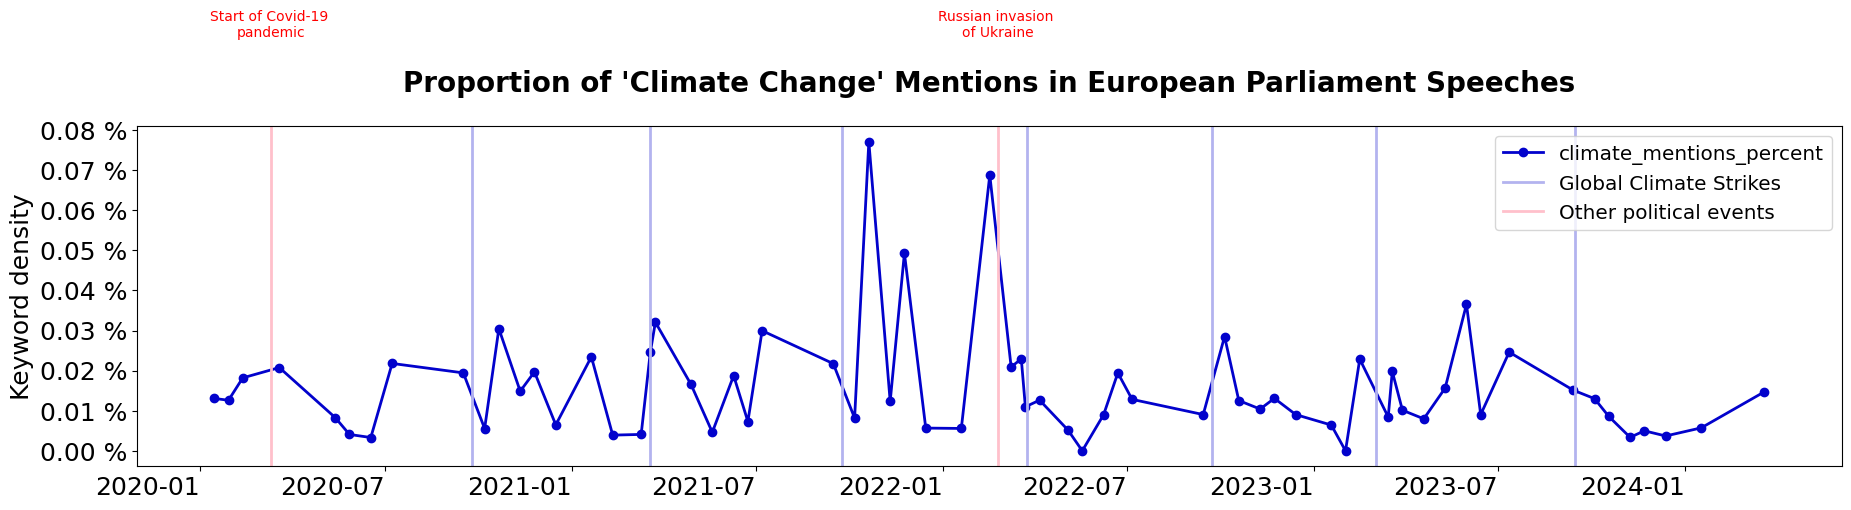

In [15]:
fig, ax = plt.subplots(figsize=(22, 5))
speeches_df['climate_mentions_percent'].plot(ax=ax, marker='o', linestyle='-', linewidth=2, color="#0202cc", fontsize=18)

ax.set_title("Proportion of 'Climate Change' Mentions in European Parliament Speeches", fontsize=20, fontweight = "bold", pad=25)
ax.set_ylabel("Keyword density",fontsize=18)
ax.set_xlabel("")

def format_func(value, tick_number):
  return '{:.2f} %'.format(value)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

gcs_dates = ["2020-09-25", "2021-03-19", "2021-09-24", "2022-03-25", "2022-09-23", "2023-03-03", "2023-09-15"]
for i in gcs_dates:
  plt.axvline(x = i, color = '#b3b3ef', label = 'Global Climate Strikes', linewidth=2)

fig.autofmt_xdate()

plt.axvline(x = "2020-03-11", color = 'pink', label = 'Other political events', linewidth=2)
plt.axvline(x = "2022-02-24", color = 'pink', label = 'Other political events', linewidth=2)
ax.text("2020-03-11", 0.11, "Start of Covid-19 \npandemic", rotation=0, verticalalignment='top', horizontalalignment='center', color="red")
ax.text("2022-02-24", 0.11, "Russian invasion \nof Ukraine", rotation=0, verticalalignment='top', horizontalalignment='center', color="red")

# Remove legend
# ax.legend().remove()
# Get legend handles and labels
handles, labels = ax.get_legend_handles_labels()
legend_dict = {label: handle for handle, label in zip(handles, labels)}
legend_dict.pop('speech_count', None)

# Create legend for each color
plt.legend(legend_dict.values(), legend_dict.keys(), loc='upper right', fontsize="x-large")


# Rotate x-axis tick labels
plt.xticks(rotation=0)

plt.show()

**Convert natural language statements of crowd size at protests into integers. For now, we leave 'unknown' as NAN, and flag them for later processing since there are various things we might decide to do here.**

In [16]:
def infer_crowd_size(tag):
  """Convert the text strings giving estimated protester counts (sometimes as a
  range) into an integer (in the middle of the range)"""

  # Start with the numerous special cases
  if any (s in tag for s in ("several", "multiple", "a few", "some", "a group",
    "a small group", "small group", "a couple", "half dozen", "half-dozen",
    "half a dozen", "a handful", "handful", "small")
  ):
    return 5

  estimates = {
    ("hundreds", "hundred"): 500,
    ("between hundreds and 2000",): 2750,
    ("thousands", "thousand"): 5000,
    ("tens of thousands",): 50_000,
    ("hundreds of thousands",): 500_000,
    ("between dozens and 250",): (50+250)//2,
    ("one to three",): 2,
    ("two dozens",): 24
  }

  for text, estimate in estimates.items():
    if any (s in tag for s in text):
      return estimate

  if any (s in tag for s in ("dozens", "tens", "tenfold", "scores", "big group",
    "large group", "numerous", "many", "large number", "numerous small groups",
    "large", "multitude")):
    return 50

  # Regex to capture Arabic numbers that may or may not include commas:
  number_pattern = '\d{1,3}(?:,?\d*)*'
  numbers = re.findall(number_pattern, tag)
  # Remove commas from numbers and then convert them to integers
  numbers = [int(num.replace(',', '')) for num in numbers]

  # If we have two or more numbers, assume it's a range, and take their mean
  mean = np.mean(numbers)

  if tag.endswith("dozen") and any(numbers):
    return mean * 12
  if tag.endswith("dozen"):
    return 12

  # Don't replace NaNs yet
  if np.isnan(mean):
    return np.nan
  return int(round(mean))

og_protests_df['protesters_estimate'] = og_protests_df['tags'].apply(infer_crowd_size)
og_protests_df['size_is_unknown'] = og_protests_df['protesters_estimate'].isna().astype(int)

/Users/sashacooper/.pyenv/versions/3.10.6/envs/climate/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sashacooper/.pyenv/versions/3.10.6/envs/climate/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


**Frustratingly, we're missing data on the size of protest for the majority of protests**

In [17]:
len(og_protests_df), sum(og_protests_df['size_is_unknown'])

(9036, 5694)

# Model 1: Naive regression, grouping protests by a large regular interval

Since we don't have a target value unless there's at least one speech, we could group all our data by regular intervals - but those intervals have to be large enough to reliably contain a speech throughout our data (which turns out to be every 70 days).


**Find the max interval between speeches**

In [18]:
dates = pd.Series(speeches_df.index)

intervals = [dates.iloc[i] - dates.iloc[i - 1] for i in range(len(speeches_df)) if i > 0] 
max_interval = max(intervals)
max_interval

Timedelta('70 days 00:00:00')

**Group each protest and each speech into some number of max_intervals (i.e. 70-day periods) from our start time**

In [19]:
def count_intervals_from_start(date):
    start_date = og_protests_df['event_date'].min()
    offset = pd.offsets.Day(max_interval.days)
    period = start_date.to_period(freq=offset)
    intervals = (date - start_date) // max_interval
    return period + intervals + 1

# Create a new column with the periods
speeches_df['grouping_period'] = speeches_df.index.map(count_intervals_from_start)

# Group by the period
y_regular = speeches_df.groupby('grouping_period')['climate_mentions_percent'].mean()
y_regular.head(3)

grouping_period
2020-03-11    0.014621
2020-05-20    0.014523
2020-07-29    0.009729
Freq: 70D, Name: climate_mentions_percent, dtype: float64

In [20]:
# Group the protests by the same interval as above
og_protests_df['grouping_period'] = og_protests_df['event_date'].map(count_intervals_from_start)

num_protests = og_protests_df.groupby('grouping_period').size()

regularised_protests_df = og_protests_df.groupby('grouping_period').agg({
    'protesters_estimate': 'sum',
    'size_is_unknown': 'sum'
}).assign(num_protests=og_protests_df.groupby('grouping_period').size())

regularised_protests_df.head(3)

,protesters_estimate,size_is_unknown,num_protests
grouping_period,,,
2020-03-11,122288.0,263,407
2020-05-20,2125.0,96,142
2020-07-29,12556.0,185,278


**For our basic model, we treat each 70-day period as unrelated, with protests having no persistent effects beyond the subsequent speech. We also assume the mean number of protesters for those with missing values**

In [21]:
class ProtestSizeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['protesters_estimate'] = X['protesters_estimate'] + X['size_is_unknown'] * og_protests_df['protesters_estimate'].mean()
        return X['protesters_estimate']


**There's already strong and robust correlations between [number of *protests* & climate mentions] and between [number of protest*ers* & climate mentions]**

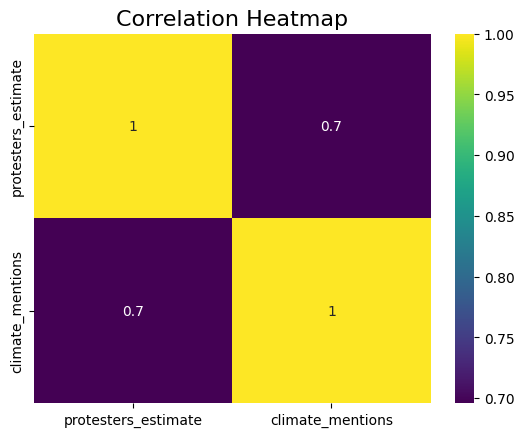

In [25]:

corr_test_df = ProtestSizeImputer().fit_transform(regularised_protests_df[['protesters_estimate', 'size_is_unknown']])
corr_test_df['climate_mentions'] = y_regular
sns.heatmap(corr_test_df.corr(), annot=True, cmap='viridis')
plt.title("Correlation Heatmap", fontsize=16);

In [26]:
cross_val_score(LinearRegression(), corr_test_df[['protesters_estimate']], corr_test_df['climate_mentions'], scoring='r2').mean()

np.float64(-0.44123450930419883)

In [24]:
corr_test_df

,protesters_estimate,climate_mentions
0,3.508951e+05,0.014621
1,8.557095e+04,0.014523
2,1.733633e+05,0.009729
3,4.383165e+05,0.019436
4,2.424767e+05,0.017640
5,1.061674e+05,0.011277
6,4.592624e+05,0.019327
7,4.462918e+05,0.015160
8,2.622736e+05,0.021741
9,1.181245e+06,0.036710
